## Import Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load and Prepare Dataset

In [2]:
def load_data(folder_path):
    train_df = pd.read_csv(os.path.join(folder_path, 'train.csv'))
    val_df = pd.read_csv(os.path.join(folder_path, 'val.csv'))
    test_df = pd.read_csv(os.path.join(folder_path, 'test.csv'))
    return train_df, val_df, test_df

## Build Vocabulary & Load GloVe Embeddings

In [3]:
def build_vocab(dataframes, vocab_size=20000):
    word_freq = defaultdict(int)
    for df in dataframes:
        for text in df['text'].astype(str):
            for word in word_tokenize(text.lower()):
                word_freq[word] += 1
    sorted_words = sorted(word_freq.items(), key=lambda x: -x[1])[:vocab_size]
    word2idx = {"<PAD>": 0, "<UNK>": 1}
    for i, (word, _) in enumerate(sorted_words, 2):
        word2idx[word] = i
    return word2idx

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))
    embeddings[0] = np.zeros(embedding_dim)  # PAD

    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            if word in word2idx:
                vector = np.array(parts[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

## Create Dataset and Dataloader

In [4]:
class SarcasmDataset(Dataset):
    def __init__(self, dataframe, word2idx, max_len=100):
        self.texts = dataframe['text'].astype(str)
        self.labels = dataframe['sarcastic'].tolist()
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        words = word_tokenize(self.texts[idx].lower())[:self.max_len]
        word_ids = [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in words]
        padded = word_ids + [0] * (self.max_len - len(word_ids))
        return torch.LongTensor(padded), self.labels[idx]

def collate_fn(batch):
    x, y = zip(*batch)
    return torch.stack(x), torch.LongTensor(y)

## FAN Model with Attention Layers

In [5]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.context = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, x):
        u = torch.tanh(self.attn(x))
        score = self.context(u).squeeze(-1)
        weights = F.softmax(score, dim=1)
        output = (x * weights.unsqueeze(-1)).sum(dim=1)
        return output

class FAN(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=64, dropout=0.3, use_glove=True):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        if use_glove == True:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        else: self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bigru = nn.GRU(embed_dim, hidden_size, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        self.attn = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.context_vector = nn.Linear(hidden_size * 2, 1, bias=False)
        self.classifier = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # x: [batch, seq_len]
        embed = self.embedding(x)
        gru_out, _ = self.bigru(embed)
        gru_out = self.dropout(gru_out)

        u = torch.tanh(self.attn(gru_out))
        attn_weights = torch.softmax(self.context_vector(u).squeeze(-1), dim=1)
        doc_vector = torch.sum(gru_out * attn_weights.unsqueeze(-1), dim=1)

        out = torch.sigmoid(self.classifier(doc_vector)).squeeze(1)
        return out

## Training & Evaluation Functions

In [6]:
def train_model(model, optimizer, train_loader, val_loader, dir_path, epochs=5):
    os.makedirs(dir_path, exist_ok=True)
    criterion = nn.BCELoss()
    history = {'train': [], 'val': []}
    model.to(device)
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.float().to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.float().to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), f"{dir_path}/model.pth")
            best_val_loss = avg_val_loss
        
        print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        history['train'].append(avg_train_loss)
        history['val'].append(avg_val_loss)

    return history

def evaluate_model(model, test_loader, dir_path):
    os.makedirs(dir_path, exist_ok=True)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            preds = model(x)
            preds = (preds > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    print(classification_report(all_labels, all_preds, zero_division=0))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(rf'{dir_path}/confusion_matrix.png')
    plt.show()

## Plot Loss Curve

In [7]:
def plot_loss(history, dir_path):
    plt.plot(history['train'], label='Train Loss')
    plt.plot(history['val'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.savefig(rf'{dir_path}/train_val_loss.png')
    plt.show()

## Run Training & Evaluation

### iSarcasmEval Dataset

In [8]:
folder_path = "iSarcasmEval"
glove_path = "glove.6B.100d.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

In [10]:
train_data = SarcasmDataset(train_df, word2idx)
val_data = SarcasmDataset(val_df, word2idx)
test_data = SarcasmDataset(test_df, word2idx)

In [11]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)

### With GloVe

Epoch 1 Train Loss: 0.5878 | Val Loss: 0.5696
Epoch 2 Train Loss: 0.5579 | Val Loss: 0.5637
Epoch 3 Train Loss: 0.5203 | Val Loss: 0.5583
Epoch 4 Train Loss: 0.2910 | Val Loss: 0.6812
Epoch 5 Train Loss: 0.1320 | Val Loss: 0.7983


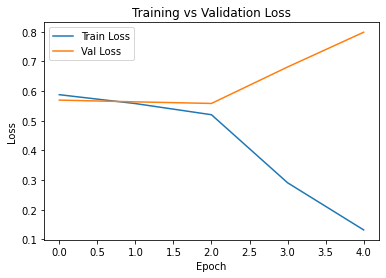

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1200
           1       0.12      0.03      0.04       200

    accuracy                           0.83      1400
   macro avg       0.49      0.50      0.48      1400
weighted avg       0.75      0.83      0.79      1400



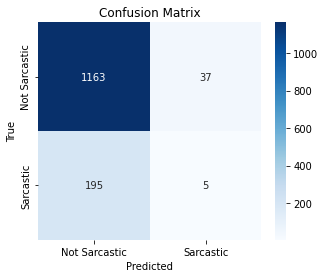

In [12]:
dir_path = 'isarc_fan_16_glove'

model = FAN(glove, hidden_size=16)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train_model(model, optimizer, train_loader, val_loader, dir_path, epochs=5)
plot_loss(history, dir_path)

model = FAN(glove, hidden_size=16)
model.load_state_dict(torch.load(f"{dir_path}/model.pth", weights_only=True))
evaluate_model(model, test_loader, dir_path)

### Without GloVe

Epoch 1 Train Loss: 0.5745 | Val Loss: 0.5635
Epoch 2 Train Loss: 0.5494 | Val Loss: 0.5679
Epoch 3 Train Loss: 0.5283 | Val Loss: 0.5523
Epoch 4 Train Loss: 0.4714 | Val Loss: 0.5578
Epoch 5 Train Loss: 0.3694 | Val Loss: 0.6101


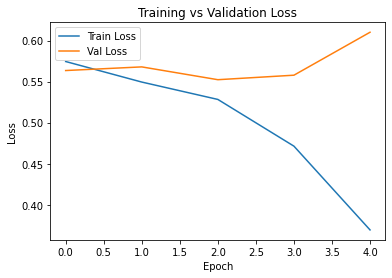

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1200
           1       0.00      0.00      0.00       200

    accuracy                           0.86      1400
   macro avg       0.43      0.50      0.46      1400
weighted avg       0.73      0.86      0.79      1400



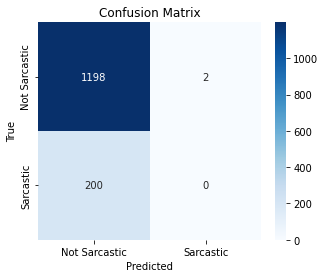

In [13]:
dir_path = 'isarc_fan_16'

model = FAN(glove, hidden_size=16, use_glove=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train_model(model, optimizer, train_loader, val_loader, dir_path, epochs=5)
plot_loss(history, dir_path)

model = FAN(glove, hidden_size=16, use_glove=False)
model.load_state_dict(torch.load(f"{dir_path}/model.pth", weights_only=True))
evaluate_model(model, test_loader, dir_path)

### Sarcasm Corpus V2 Dataset

In [14]:
folder_path = "Sarcasm_Corpus_V2"

In [15]:
train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

In [16]:
train_data = SarcasmDataset(train_df, word2idx)
val_data = SarcasmDataset(val_df, word2idx)
test_data = SarcasmDataset(test_df, word2idx)

In [17]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)

### With GloVe

Epoch 1 Train Loss: 0.6038 | Val Loss: 0.5191
Epoch 2 Train Loss: 0.4599 | Val Loss: 0.5024
Epoch 3 Train Loss: 0.2936 | Val Loss: 0.6111
Epoch 4 Train Loss: 0.1513 | Val Loss: 0.7165
Epoch 5 Train Loss: 0.0701 | Val Loss: 0.9447


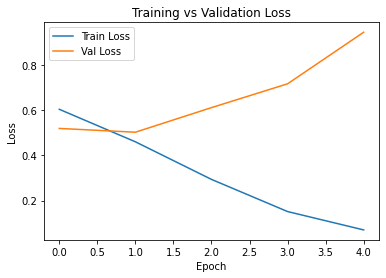

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       938
           1       0.76      0.69      0.73       940

    accuracy                           0.74      1878
   macro avg       0.74      0.74      0.74      1878
weighted avg       0.74      0.74      0.74      1878



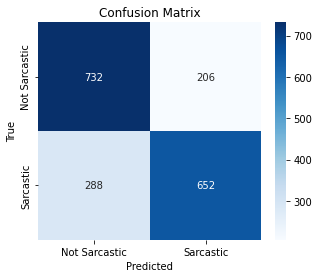

In [18]:
dir_path = 'scv2_fan_16_glove'

model = FAN(glove, hidden_size=16)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train_model(model, optimizer, train_loader, val_loader, dir_path, epochs=5)
plot_loss(history, dir_path)

model = FAN(glove, hidden_size=16)
model.load_state_dict(torch.load(f"{dir_path}/model.pth", weights_only=True))
evaluate_model(model, test_loader, dir_path)

### Without GloVe

Epoch 1 Train Loss: 0.6377 | Val Loss: 0.5927
Epoch 2 Train Loss: 0.5369 | Val Loss: 0.5737
Epoch 3 Train Loss: 0.4312 | Val Loss: 0.5651
Epoch 4 Train Loss: 0.3247 | Val Loss: 0.6379
Epoch 5 Train Loss: 0.2233 | Val Loss: 0.7079


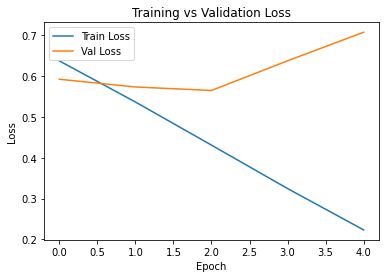

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       938
           1       0.72      0.71      0.72       940

    accuracy                           0.72      1878
   macro avg       0.72      0.72      0.72      1878
weighted avg       0.72      0.72      0.72      1878



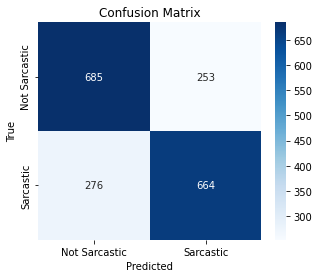

In [19]:
dir_path = 'scv2_fan_16'

model = FAN(glove, hidden_size=16, use_glove=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train_model(model, optimizer, train_loader, val_loader, dir_path, epochs=5)
plot_loss(history, dir_path)

model = FAN(glove, hidden_size=16, use_glove=False)
model.load_state_dict(torch.load(f"{dir_path}/model.pth", weights_only=True))
evaluate_model(model, test_loader, dir_path)

### Combined Dataset

In [20]:
folder_path = "combined"

In [21]:
train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

In [22]:
train_df, val_df, test_df = load_data(folder_path)
word2idx = build_vocab([train_df, val_df, test_df])
glove = load_glove_embeddings(glove_path, word2idx)

In [23]:
train_data = SarcasmDataset(train_df, word2idx)
val_data = SarcasmDataset(val_df, word2idx)
test_data = SarcasmDataset(test_df, word2idx)

In [24]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)

### With GloVe

Epoch 1 Train Loss: 0.6156 | Val Loss: 0.5555
Epoch 2 Train Loss: 0.4875 | Val Loss: 0.5644
Epoch 3 Train Loss: 0.3237 | Val Loss: 0.6147
Epoch 4 Train Loss: 0.1857 | Val Loss: 0.7766
Epoch 5 Train Loss: 0.0924 | Val Loss: 0.9816


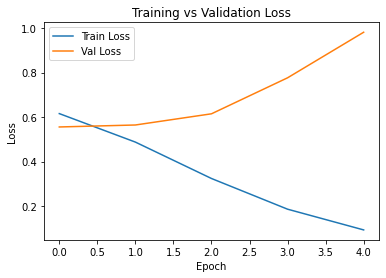

              precision    recall  f1-score   support

           0       0.83      0.77      0.79      2138
           1       0.61      0.70      0.65      1140

    accuracy                           0.74      3278
   macro avg       0.72      0.73      0.72      3278
weighted avg       0.75      0.74      0.75      3278



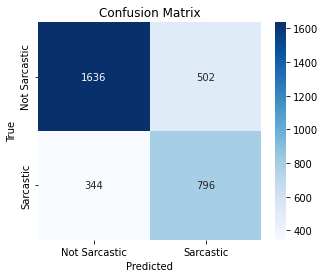

In [25]:
dir_path = 'comb_fan_16_glove'

model = FAN(glove, hidden_size=16)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train_model(model, optimizer, train_loader, val_loader, dir_path, epochs=5)
plot_loss(history, dir_path)

model = FAN(glove, hidden_size=16)
model.load_state_dict(torch.load(f"{dir_path}/model.pth", weights_only=True))
evaluate_model(model, test_loader, dir_path)

### Without GloVe

Epoch 1 Train Loss: 0.6406 | Val Loss: 0.6097
Epoch 2 Train Loss: 0.5688 | Val Loss: 0.5913
Epoch 3 Train Loss: 0.4784 | Val Loss: 0.5907
Epoch 4 Train Loss: 0.3726 | Val Loss: 0.6393
Epoch 5 Train Loss: 0.2658 | Val Loss: 0.7309


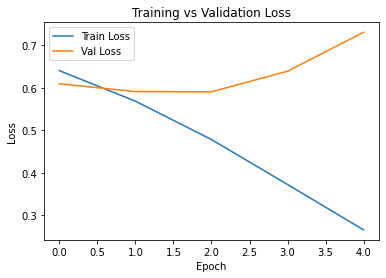

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      2138
           1       0.59      0.57      0.58      1140

    accuracy                           0.71      3278
   macro avg       0.68      0.68      0.68      3278
weighted avg       0.71      0.71      0.71      3278



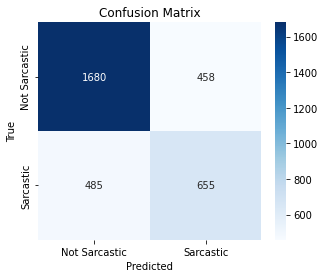

In [26]:
dir_path = 'comb_fan_16'

model = FAN(glove, hidden_size=16, use_glove=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train_model(model, optimizer, train_loader, val_loader, dir_path, epochs=5)
plot_loss(history, dir_path)

model = FAN(glove, hidden_size=16, use_glove=False)
model.load_state_dict(torch.load(f"{dir_path}/model.pth", weights_only=True))
evaluate_model(model, test_loader, dir_path)